In [1]:
import numpy as np
import collections
from torch.utils import data

import sys
sys.path.append('.')
sys.path.append('../')

from einops import rearrange

import torch
import torch.nn as nn
from torch.nn import functional as FeatureAlphaDropout
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from scipy import io as scipyio
import skimage
import skvideo.io

import os
import glob
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"
sys.path.append("neuroformer")

In [5]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [6]:
from utils import set_seed
set_seed(25)

In [8]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

stim_folder = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli"
im_path = ['/Combined Stimuli 3-grating.tif',
           '/Combined Stimuli 3-Movie2.tif',
           '/Combined Stimuli 3-Movie3.tif']

train_path = "/content/stimulus"
train_path = "/Users/antonis/Downloads/OneCombo3/stimuli"
video_stack = [skimage.io.imread(stim_folder + vid) for vid in im_path]
print(glob.glob(train_path + '/*.tif'))
video_stack = np.concatenate(video_stack, axis=0)

# video_stack = skimage.io.imread("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif")
# video_stack = image_dataset(video_stack)
# video_stack = video_stack[::3]  # convert from 60 to 20 fps
# video_stack = video_stack.view(1, video_stack.shape[0], video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])
# video_stack = video_stack.transpose(-1, -2)

# rearrange(video_stack[0, 0:2].transpose(0,1), 'c t (h p1) (w p2) -> (t h w) (p1 p2 c)', p1=16, p2=16).shape

[]
im_sack size: torch.Size([5760, 1, 64, 112])


In [9]:
video_stack.shape

torch.Size([3, 640, 1, 64, 112])

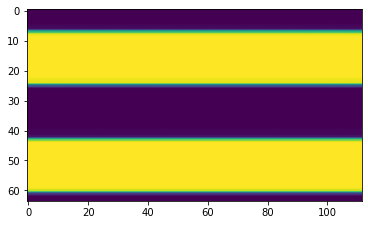

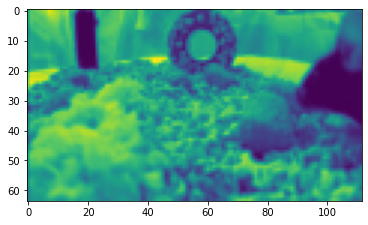

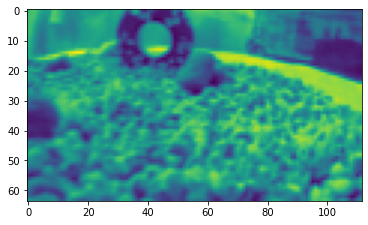

In [10]:
plt.figure()
plt.imshow(video_stack[0, 1, 0].permute(0, 1))
plt.figure()
plt.imshow(video_stack[1, 1, 0].permute(0, 1))
plt.figure()
plt.imshow(video_stack[2, 1, 0].permute(0, 1))

In [11]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_combo3

spike_data = scipyio.loadmat("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/spiketrain.mat")
spike_data = np.squeeze(spike_data['spiketrain'].T, axis=-1)
spike_data = [trial_df_combo3(spike_data, n_stim) for n_stim in range(3)]
spike_data = pd.concat(spike_data, axis=0)

spike_data['Trial'] = spike_data['Trial'] + 1
spike_data['Time'] = spike_data['Time'] * 0.0751
spike_data = spike_data[(spike_data['Time'] > 0) & (spike_data['Time'] <= 32)]

# vid_duration = [len(vid) * 1/20 for vid in vid_list]

df = spike_data
del spike_data

In [23]:
# df_sim = pd.read_csv("data/full_sim__model_weighted_shuffle_decay_True_perceiver_2.0_dt_0.05_eos_8_8_256.csv").iloc[1:, 1:].reset_index(drop=True)
# df_sim = df_sim[df_sim['ID'] <= 164]
# df_sim['Trial'] = df_sim['Trial'] + df['Trial'].max()
# df = pd.concat([df, df_sim], axis=0)

In [12]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.05

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
# df['Interval_dt'] = make_intervals(df, dt)
# df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(3)
df = df.reset_index(drop=True)

In [13]:
# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
dt_range = int(window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)]
df['Time'] = df['Time'].round(3)

In [14]:
n_dt

[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

In [15]:
# df.groupby(['Interval', 'Trial']).size().plot.bar()
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
df.groupby(['Interval', 'Trial']).size().nlargest(100)

Interval  Trial
18.5      42       49
4.5       45       36
26.0      49       35
29.0      26       35
4.0       23       33
                   ..
          29       21
          33       21
4.5       22       21
7.0       13       21
7.5       7        21
Length: 100, dtype: int64

In [16]:
from SpikeVidUtils import SpikeTimeVidData

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
frame_feats = video_stack.transpose(1, 2)

frame_block_size = 560
prev_id_block_size = 52
id_block_size = 52   # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
# pixels = sorted(np.unique(frames).tolist())
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

0.5

In [17]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = []
for n_stim in range(df['Trial'].max() // 20):
    n_trial = [3, 15, 5, 18]
    for n_trial in n_trial:
        trial = (n_stim + 1) * 20 - n_trial
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [18]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
# single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], None, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats)
small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)


print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

Length: 20449 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 5163 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 393 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
train: 2941, test: 729


In [19]:
def get_class_weights(dataset):
  dt = []
  id = []
  for x, y in dataset:
    id.extend([stoi['SOS']] + y['id'][:len(y['id']) - x['pad']].flatten().tolist() + [stoi['PAD']]) # -1 in pad to include PAD token
    dt.extend([stoi_dt[0]] + y['dt'][:len(y['dt']) - x['pad']].flatten().tolist() + [dataset.dt_max]) # -1 in pad to include PAD token

  id = pd.DataFrame(id)
  dt = pd.DataFrame(dt)

  id_freq = id.groupby([0]).size()
  dt_freq = dt.groupby([0]).size()

  id_ones = np.ones(dataset.id_population_size)
  dt_ones = np.ones(dataset.dt_population_size)

  id_ones[id_freq.index] = (1 / id_freq) * id_freq.max() / id_freq.max()
  dt_ones[dt_freq.index] = (1 / dt_freq) * dt_freq.max() / dt_freq.max()
  
  class_freq = dict()
  class_freq['id'] = torch.tensor(id_ones, dtype=torch.float32)
  class_freq['dt'] = torch.tensor(dt_ones, dtype=torch.float32)
  
  return class_freq 

class_weights = get_class_weights(train_dataset)

In [22]:
from model_perceiver import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=class_weights,
                        pretrain=True,
                        n_layer=8, n_head=8, n_embd=256,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.2, im_drop=0.2)
model = GPT(mconf)
# model.load_state_dict(torch.load("models/model_weighted_shuffle_nodecay:True_perceiver_2.0_dt:0.05_eos_8_8_256.pt", map_location='cpu'))

02/01/2022 12:39:35 - INFO - model_perceiver -   number of parameters: 3.358669e+07


In [39]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_8_4_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_shuffle_8_4_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_81_4_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_83_4_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_dt_8_4_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_dt_8_8_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_dt_eos_8_8_256.pt"))
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_2.0_dt_eos_8_8_256.pt"))
# model.load_state_dict(torch.load(f"/content/drive/MyDrive/slab/models/OneCombo3/model_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt"))
# model.load_state_dict(torch.load(f"/content/drive/MyDrive/slab/models/OneCombo3/model_shuffle_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt"))


In [40]:
# loader = DataLoader(small_dataset, shuffle=False, pin_memory=False,
#                                   batch_size=1, num_workers=1)
# x, y = next(iter(loader))
# model = model.to('cpu')

# preds, features, loss = model(x, y)

In [41]:
from trainer import Trainer, TrainerConfig
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-01-21-14:18-e:19-b:239-l:4-h:2-ne:512-higher_order.pt"))
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-14-21-23:44-e:17-b:650-l:8-h:4-ne:256-higher_order.pt"))

max_epochs = 400
batch_size = 32
shuffle = False
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=8e-5, 
                      num_workers=4, lr_decay=True, warmup_tokens=4e5, 
                      decay_weights=True, shuffle=shuffle,
                      final_tokens=len(train_dataset)*(block_size // 8) * (max_epochs),
                      clip_norm=1.0, grad_norm_clip=2.0,
                      dataset='higher_order', mode='predict',
                      block_size=train_dataset.block_size,
                      id_block_size=train_dataset.id_block_size,
                      show_grads=False, plot_raster=False,
                      ckpt_path=f"/home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt")

trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
trainer.train()  

epoch 1  id_train: 2.57936  time_train: 1.01023  total_loss: 3.58959 lr 6.256640e-05: 100%|██████████| 189/189 [00:46<00:00,  4.04it/s]
01/29/2022 19:23:00 - INFO - trainer -   id_test: 2.58935    time_test: 1.19292  total_loss: 3.78227
01/29/2022 19:23:01 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 2  id_train: 2.51761  time_train: 0.88208  total_loss: 3.39968 lr 7.995520e-05: 100%|██████████| 189/189 [00:46<00:00,  4.04it/s]
01/29/2022 19:23:48 - INFO - trainer -   id_test: 2.55821    time_test: 1.09709  total_loss: 3.65529
01/29/2022 19:23:48 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 3  id_train: 2.52729  time_train: 0.79585  total_loss: 3.32315 lr 7.995520e-05: 100%|██████████| 189/189 [00:46<00:00,  4.04it/s]
01/29/2022 19:24:35 - INFO - trainer -  

Epoch    16: reducing learning rate of group 0 to 2.3987e-05.
Epoch    16: reducing learning rate of group 1 to 2.3987e-05.


epoch 17  id_train: 2.39434  time_train: 0.60506  total_loss: 2.99940 lr 2.398656e-05: 100%|██████████| 189/189 [00:40<00:00,  4.65it/s]
01/29/2022 19:34:36 - INFO - trainer -   id_test: 2.40289    time_test: 1.02410  total_loss: 3.42699
epoch 18  id_train: 2.36693  time_train: 0.62818  total_loss: 2.99511 lr 2.398656e-05: 100%|██████████| 189/189 [00:45<00:00,  4.19it/s]
01/29/2022 19:35:21 - INFO - trainer -   id_test: 2.39940    time_test: 0.98355  total_loss: 3.38295
01/29/2022 19:35:21 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 19  id_train: 2.34565  time_train: 0.62355  total_loss: 2.96920 lr 2.398656e-05: 100%|██████████| 189/189 [00:45<00:00,  4.16it/s]
01/29/2022 19:36:07 - INFO - trainer -   id_test: 2.39417    time_test: 1.00361  total_loss: 3.39778
epoch 20  id_train: 2.35083  time_train: 0.61109  total_loss: 2.96193 lr 2.398656e-05: 100%|██████████| 189/189

Epoch    23: reducing learning rate of group 0 to 7.1960e-06.
Epoch    23: reducing learning rate of group 1 to 7.1960e-06.


epoch 24  id_train: 2.35054  time_train: 0.62808  total_loss: 2.97862 lr 7.195968e-06: 100%|██████████| 189/189 [00:46<00:00,  4.10it/s]
01/29/2022 19:39:59 - INFO - trainer -   id_test: 2.40048    time_test: 0.96047  total_loss: 3.36095
01/29/2022 19:39:59 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 25  id_train: 2.34143  time_train: 0.63474  total_loss: 2.97617 lr 7.195968e-06: 100%|██████████| 189/189 [00:45<00:00,  4.13it/s]
01/29/2022 19:40:46 - INFO - trainer -   id_test: 2.40024    time_test: 0.94615  total_loss: 3.34640
01/29/2022 19:40:46 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 26  id_train: 2.31203  time_train: 0.60844  total_loss: 2.92048 lr 7.195968e-06: 100%|██████████| 189/189 [00:46<00:00,  4.10it/s]
01/29/2022 19:41:33 - INFO - trainer 

Epoch    41: reducing learning rate of group 0 to 2.1588e-06.
Epoch    41: reducing learning rate of group 1 to 2.1588e-06.


epoch 42  id_train: 2.32321  time_train: 0.65264  total_loss: 2.97585 lr 2.158790e-06: 100%|██████████| 189/189 [00:40<00:00,  4.69it/s]
01/29/2022 19:52:33 - INFO - trainer -   id_test: 2.39965    time_test: 0.90193  total_loss: 3.30159
epoch 43  id_train: 2.29500  time_train: 0.63085  total_loss: 2.92584 lr 2.158790e-06: 100%|██████████| 189/189 [00:40<00:00,  4.72it/s]
01/29/2022 19:53:13 - INFO - trainer -   id_test: 2.39967    time_test: 0.89834  total_loss: 3.29800
01/29/2022 19:53:13 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 44  id_train: 2.24615  time_train: 0.60650  total_loss: 2.85265 lr 2.158790e-06: 100%|██████████| 189/189 [00:40<00:00,  4.68it/s]
01/29/2022 19:53:54 - INFO - trainer -   id_test: 2.40013    time_test: 0.90114  total_loss: 3.30127
epoch 45  id_train: 2.31857  time_train: 0.62708  total_loss: 2.94565 lr 2.158790e-06: 100%|██████████| 189/189

Epoch    51: reducing learning rate of group 0 to 6.4764e-07.
Epoch    51: reducing learning rate of group 1 to 6.4764e-07.


epoch 52  id_train: 2.27943  time_train: 0.67215  total_loss: 2.95158 lr 6.476371e-07: 100%|██████████| 189/189 [00:39<00:00,  4.73it/s]
01/29/2022 19:59:18 - INFO - trainer -   id_test: 2.39904    time_test: 0.88746  total_loss: 3.28650
01/29/2022 19:59:18 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 53  id_train: 2.30411  time_train: 0.62303  total_loss: 2.92714 lr 6.476371e-07: 100%|██████████| 189/189 [00:39<00:00,  4.75it/s]
01/29/2022 19:59:59 - INFO - trainer -   id_test: 2.39921    time_test: 0.88629  total_loss: 3.28550
01/29/2022 19:59:59 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 54  id_train: 2.29336  time_train: 0.63832  total_loss: 2.93167 lr 6.476371e-07: 100%|██████████| 189/189 [00:39<00:00,  4.81it/s]
01/29/2022 20:00:39 - INFO - trainer 

Epoch    60: reducing learning rate of group 0 to 1.9429e-07.
Epoch    60: reducing learning rate of group 1 to 1.9429e-07.


epoch 61  id_train: 2.30982  time_train: 0.64370  total_loss: 2.95352 lr 1.942911e-07: 100%|██████████| 189/189 [00:39<00:00,  4.83it/s]
01/29/2022 20:05:17 - INFO - trainer -   id_test: 2.39914    time_test: 0.87721  total_loss: 3.27635
01/29/2022 20:05:17 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 62  id_train: 2.27603  time_train: 0.62792  total_loss: 2.90395 lr 1.942911e-07: 100%|██████████| 189/189 [00:39<00:00,  4.84it/s]
01/29/2022 20:05:57 - INFO - trainer -   id_test: 2.39913    time_test: 0.87489  total_loss: 3.27402
01/29/2022 20:05:57 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 63  id_train: 2.29961  time_train: 0.66583  total_loss: 2.96545 lr 1.942911e-07: 100%|██████████| 189/189 [00:39<00:00,  4.81it/s]
01/29/2022 20:06:37 - INFO - trainer 

Epoch    68: reducing learning rate of group 0 to 5.8287e-08.
Epoch    68: reducing learning rate of group 1 to 5.8287e-08.


epoch 69  id_train: 2.28931  time_train: 0.63877  total_loss: 2.92808 lr 5.828734e-08: 100%|██████████| 189/189 [00:39<00:00,  4.83it/s]
01/29/2022 20:10:36 - INFO - trainer -   id_test: 2.39916    time_test: 0.87163  total_loss: 3.27079
01/29/2022 20:10:36 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 70  id_train: 2.28889  time_train: 0.63375  total_loss: 2.92264 lr 5.828734e-08: 100%|██████████| 189/189 [00:39<00:00,  4.83it/s]
01/29/2022 20:11:16 - INFO - trainer -   id_test: 2.39916    time_test: 0.87126  total_loss: 3.27042
01/29/2022 20:11:16 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 71  id_train: 2.27794  time_train: 0.61608  total_loss: 2.89402 lr 5.828734e-08: 100%|██████████| 189/189 [00:39<00:00,  4.82it/s]
01/29/2022 20:11:56 - INFO - trainer 

Epoch    73: reducing learning rate of group 0 to 1.7486e-08.
Epoch    73: reducing learning rate of group 1 to 1.7486e-08.


epoch 74  id_train: 2.26988  time_train: 0.62239  total_loss: 2.89227 lr 1.748620e-08: 100%|██████████| 189/189 [00:39<00:00,  4.81it/s]
01/29/2022 20:13:55 - INFO - trainer -   id_test: 2.39915    time_test: 0.87048  total_loss: 3.26963
01/29/2022 20:13:55 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 75  id_train: 2.27973  time_train: 0.61726  total_loss: 2.89699 lr 1.748620e-08: 100%|██████████| 189/189 [00:39<00:00,  4.82it/s]
01/29/2022 20:14:35 - INFO - trainer -   id_test: 2.39915    time_test: 0.87042  total_loss: 3.26956
01/29/2022 20:14:35 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 76  id_train: 2.29586  time_train: 0.63185  total_loss: 2.92771 lr 1.748620e-08: 100%|██████████| 189/189 [00:39<00:00,  4.84it/s]
01/29/2022 20:15:15 - INFO - trainer 

Epoch    78: reducing learning rate of group 0 to 5.2459e-09.
Epoch    78: reducing learning rate of group 1 to 5.2459e-09.


epoch 79  id_train: 2.29232  time_train: 0.61343  total_loss: 2.90575 lr 5.245861e-09: 100%|██████████| 189/189 [00:39<00:00,  4.84it/s]
01/29/2022 20:17:14 - INFO - trainer -   id_test: 2.39914    time_test: 0.87007  total_loss: 3.26922
01/29/2022 20:17:14 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 80  id_train: 2.27502  time_train: 0.64014  total_loss: 2.91516 lr 5.245861e-09: 100%|██████████| 189/189 [00:39<00:00,  4.83it/s]
01/29/2022 20:17:54 - INFO - trainer -   id_test: 2.39914    time_test: 0.87004  total_loss: 3.26919
01/29/2022 20:17:54 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:False_perceiver_2.0_dt:0.05_eos_8_8_256.pt
epoch 81  id_train: 2.27628  time_train: 0.63920  total_loss: 2.91548 lr 5.245861e-09: 100%|██████████| 189/189 [00:39<00:00,  4.81it/s]
01/29/2022 20:18:34 - INFO - trainer 

In [ ]:
loader = DataLoader(test_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)
                                  

In [ ]:
iterable = iter(loader)

In [ ]:
x, y = next(iterable)

In [ ]:
x['id_prev']

In [ ]:
x['id']

In [ ]:
x.keys()

In [ ]:
x['trial'].shape

In [ ]:
x['id']

In [ ]:
x['id_prev']

In [23]:
""" Predict using TEST dataset """

from utils import predict_raster, predict_raster_resnet, predict_raster_enc_dec, predict_raster_recursive, predict_beam_search, predict_raster_recursive_time, predict_raster_recursive_time_auto, predict_beam_search_time, predict_raster_hungarian
from utils import set_plot_params
set_plot_params()
%matplotlib inline

loader = DataLoader(test_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)

# device = torch.cuda.current_device()
# model = model.to(device)
model.load_state_dict(torch.load("/home/antonis/projects/slab/git/neuroformer/models/model_weighted_shuffle:True_perceiver_2.0_dt:0.05_eos_8_8_256.pt"))

""" 

To predict only neurons we pass <frame_end> so we see predictions only for Neurons 
If you want to also see frame_tokens, just pass <frame_end=0>

NOTE: 512 ID is the <end-of-sequence-id>. Right now, makes no difference if I include
it in loss, here it is included in loss and predictions.

"""
# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted = predict_raster(model, loader)

# true, predicted = predict_beam_search(model, loader, stoi, frame_end=0)
# true, predicted, true_timing = predict_raster_recursive(model, loader, stoi, sample=True, top_p=0.95, gpu=True, frame_end=0)
results = predict_raster_recursive_time_auto(model, loader, window, stoi, itos_dt, sample=True, top_p=0.95, top_p_t=0.95, frame_end=0, get_dt=True, gpu=False)

# true, predicted = predict_raster_hungarian(model, loader)
# true, predicted = predict_raster(model, loader, gpu=True)

# true_df = pd.DataFrame(true.numpy())
# predicted_df = pd.DataFrame(predicted.numpy())
# print(len(true_df[true_df[0] == 512]), len(predicted_df[predicted_df[0] == 512])) 

100%|██████████| 729/729 [02:21<00:00,  5.17it/s]


In [24]:
# results = predict_raster_recursive_time_auto(model, loader, window, stoi, itos_dt, sample=True, top_p=0.95, top_p_t=0.95, frame_end=0, get_dt=True, gpu=False)

pred_keys = ['pred', 'time_pred', 'trial', 'interval']
predicted_dict = {k: results[k] for k in results if k in pred_keys}
df_pred = pd.DataFrame(predicted_dict)
df_pred.rename({'pred':'ID', 'time_pred':'dt', 'trial':'Trial'}, axis=1, inplace=True)
df_pred['Time'] = df_pred['dt'] + df_pred['interval'] - 0.5
# df_true['time'] = df_true['dt'] + df_true['interval'] - 0.5

In [25]:
true_keys = ['true', 'time']
true_dict = {k: results[k] for k in results if k in true_keys}
df_true = pd.DataFrame(true_dict)
df_true.rename({'true':'ID', 'time':'dt'}, axis=1, inplace=True)

In [ ]:
# predicted_timing = [itos_dt[int(dt)] for dt in predicted_timing]
# df_pred = pd.DataFrame({'True':true, 'Predicted':predicted, 'Time':true_timing, 'Predicted_Time':predicted_timing})    # Time':test_data['Time']})
# df_pred.to_csv(f"/content/drive/MyDrive/slab/predictions/OneCombo3/model_weighted_shuffle:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.csv")

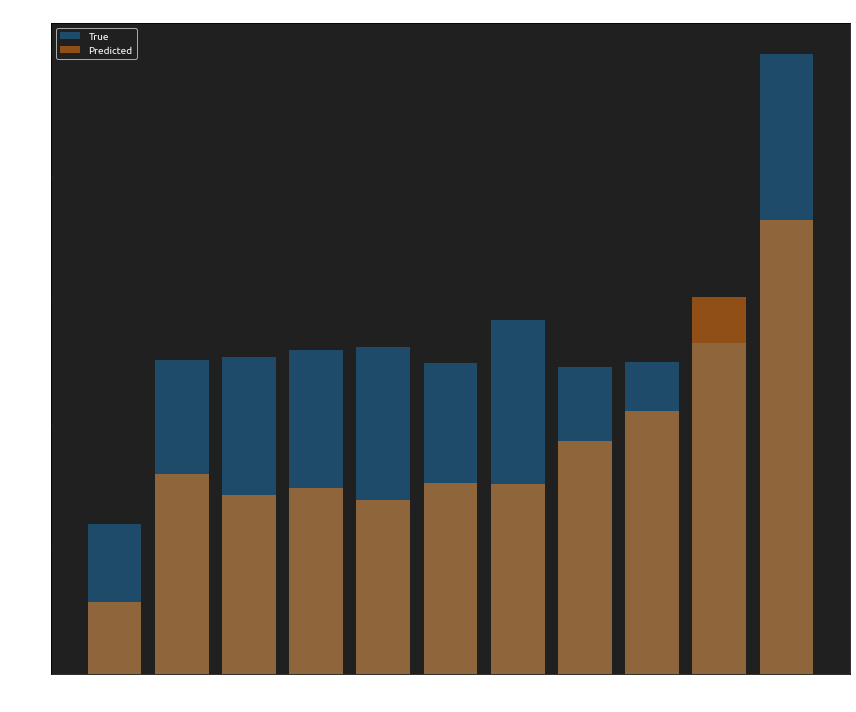

In [26]:
# df_dt = [y['dt'][:len(y['dt']) - (x['pad'])] for x, y in test_dataset]
plt.figure(figsize=(12,10))

# df_dt = df_true['time']
freq_dt_true = df_true.groupby(['dt']).size()
# freq_dt_true = df_sim.groupby(['dt']).size()
plt.bar(np.arange(len(freq_dt_true.index)), freq_dt_true, alpha=0.5, label='True')


# df_dt_pred = df_pred['time_pred']
freq_dt_pred = df_pred.groupby(['dt']).size()
plt.bar(np.arange(len(freq_dt_pred.index)), freq_dt_pred, alpha=0.5, label='Predicted')


# plt.xticks(ticks=pd.to_numeric(freq_dt_pred.index)labels=pd.to_numeric(freq_dt_pred.index))
plt.title('dt Interval Groups')
plt.xlabel('dt Group (n x 0.05s)')
plt.ylabel('Count (N)')

plt.legend()

plt.tight_layout()
# plt.savefig("dt_interval_dist.png", dpi=300)
